# Bayesian Coresets using Edward

In this notebook we try out Bayesian coresets \[1\]\[2\] exploiting Tensorflow/Edward \[4\] for the definition of models, for their derivation, for posterior approximation, and for sampling. We rely on the code made availabe by Trevor Campbell for computing coresets \[3\].

The notebook is divided in three parts:
1. **Setup**: defining the data and the model;
2. **Bayesian coresets**: computing and visualizing Bayesian coresets;
3. **Bayesian logistic regression**: evaluating classification on the original data and on coresets.

<font color='red'>**ISSUES**: still to correct/review: (i) Low acceptance rate of Metropolis-Hastings; (ii) proper way to handle coreset weights instead of upsampling.
</font>

## 1. Setup

In this first section we define parameters and auxiliary functions, we generate and show the data, and we define the statistical model.

### Importing libraries

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import tensorflow as tf
import edward as ed
import bcoresets as bc

### Setting a random seed

In [2]:
np.random.seed(742)

### Defining the projection code

We copy the code from bayesiancoresets.projection \[3\] and slightly edit it to make it work with Edward models.
Specifically:

- **ProjectionF.\_\_init\_\_()** now receives:
  - *data*: as before
  - *grad_log_likelihood*: an Edward model for the gradient of the log-likelihood </li>
  - *projection_dim*: as before </li>
  - *approx_posterior*: an Edward model for the posterior
- **ProjectionF.\_sample\_component()** was changed to exploit Edward objects. The posterior is sampled using *.sample()*, while the gradient of the log-likelihood is estimated using *.eval()*. Notice, though, the use of the iterator because the *.gradients()* function in Tensorflow defines automatically a sum over the gradients.
- **Projection.\_\_init\_\_()** was changed only to manipulate Edward objects.


In [3]:
class _Projection(object):
    def __init__(self, N, projection_dim, approx_posterior):
        self.dim = approx_posterior.shape[0].value
        self.x = np.zeros((N, 0))
        self.approx_posterior = approx_posterior
        self.update_dimension(projection_dim)
        return

    def update_dimension(self, projection_dim):
        if projection_dim < self.x.shape[1]:
            self.x = self.x[:, :projection_dim]

        if projection_dim > self.x.shape[1]:
            old_dim = self.x.shape[1]
            w = np.zeros((self.x.shape[0], projection_dim))
            w[:, :old_dim] = self.x
            w *= np.sqrt(old_dim)
            for j in range(projection_dim-old_dim):
                w[:, j+old_dim] = self._sample_component()
            w /= np.sqrt(projection_dim)
            self.x = w
        return

    def get(self):
        return self.x.copy()

In [4]:
class ProjectionF(_Projection):
    def __init__(self, data, grad_log_likelihood, projection_dim, approx_posterior):
        self.data = data
        self.grad_log_likelihood = grad_log_likelihood
        _Projection.__init__(self, data.shape[0], projection_dim, approx_posterior)
  
    def _sample_component(self):
        sample_post = self.approx_posterior.sample().eval()
        
        sgll = [self.grad_log_likelihood.eval(feed_dict={X:self.data[i].reshape([1,self.data.shape[1]]),
                                                         theta:sample_post})
                for i in range(self.data.shape[0])]
        sgll = np.array(sgll)
                
        return np.sqrt(self.dim)*sgll[:,np.random.randint(self.dim)]

### Defining the params of the simulation

We define the parameters of the simulation, including the number and dimensionality of the samples we will generate (*nsamples*, *ndims*); the number of random projection dimension and core samples for coreset computation (*nrandomdims*, *ncoresamples*); and a grid step to plot contour plots (*gridstep*).

In [5]:
nsamples = 200
ndims = 2

nrandomdims = 100
ncoresamples = 20

gridstep = .1

### Data generation

We generate data from two Gaussian distributions. We use two-dimensional data for ease of visualization.

In [6]:
mu1 = np.array([2,2])
sigma1 = np.array([[1,0],[0,1]])
mu2 = np.array([-2,-2])
sigma2 = np.array([[3,.5],[.5,1]])

pdf1 = stats.multivariate_normal(mu1,sigma1)
pdf2 = stats.multivariate_normal(mu2,sigma2)

X_pdf1 = pdf1.rvs(size=nsamples)
Y_pdf1 = np.ones(nsamples).reshape((nsamples,1))*-1
X_pdf2 = pdf2.rvs(size=nsamples)
Y_pdf2 = np.ones(nsamples).reshape((nsamples,1))
Xtr = np.vstack((X_pdf1,X_pdf2))
Ytr = np.vstack((Y_pdf1,Y_pdf2))

permutation = np.random.permutation(nsamples*2)
Xtr = Xtr[permutation]
Ytr = Ytr[permutation]

### Data visualization

We plot the data we generated.

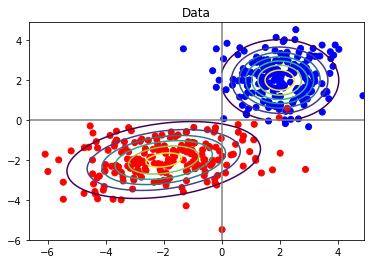

In [8]:
xmeshgrid, ymeshgrid = np.mgrid[-7:7:gridstep, -6:6:gridstep]
xymeshgrid = np.c_[xmeshgrid.ravel(), ymeshgrid.ravel()]

ycolors = np.array(['b']*Ytr.shape[0])
ycolors[Ytr[:,0]==1] = 'r'

plt.figure()
plt.title('Data')
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

xcontourgrid, ycontourgrid = np.mgrid[0:5:gridstep, 0:5:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf1.pdf(xycontourgrid))

xcontourgrid, ycontourgrid = np.mgrid[-6:2:gridstep, -6:2:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf2.pdf(xycontourgrid))


### Defining the model

We define our standard Bayesian regression model as:
$$
P(Y \vert \theta) \sim Bern (p = \sigma(X \theta))
$$
where $\theta$ is the two-dimensional vector of parameters and $\sigma(x) = \frac{1}{1+\exp{-x}}$ is the logistic function.

We also define the log-likelihood of the models and we use Tensorflow for the definition of the gradient of the log-likelihood.

In [14]:
X = tf.placeholder(tf.float32,[None,2])
theta = ed.models.Normal(loc=tf.zeros(2),scale=tf.ones(2))
y = ed.models.Bernoulli(probs=tf.sigmoid(ed.dot(X,theta)))

log_likelihood = tf.log(tf.sigmoid(ed.dot(X,theta)))
grad_log_likelihood = tf.gradients(log_likelihood,[theta])[0]

## 2. Bayesian Coresets

In this second part we compute and plot different types of coresets (GIGA, Frank-Wolfe, OrthoPursuit, and Random Subsampling).

### Performing Laplace approximation

We rely on Edward to compute a cheap posterior approximation, using Laplace approximation.
Notice that we need to define the additional hyper-parameter of the number of iteration (*n_iter*) for the computation of the Laplace approximation. This value was set by hand here-- setting this value too high causes the computation too fails due to NaN values in the computation.

In [15]:
qtheta = ed.models.MultivariateNormalTriL(
                    loc = tf.Variable(tf.zeros(ndims)),
                    scale_tril = tf.Variable(tf.eye(ndims,ndims)))
 
inference = ed.Laplace({theta:qtheta}, {X:Xtr,y:Ytr.reshape((nsamples*2))})
inference.run(n_iter=15)

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


### Performing random projection

We discretize and random-project our log-likelihoods.

In [16]:
randomprojection = ProjectionF(Xtr, grad_log_likelihood, nrandomdims, qtheta)
vecs = randomprojection.get()

### Computing the coresets

We compute the coresets for our data.

In [24]:
bc_giga = bc.GIGA(vecs)
bc_giga.run(ncoresamples)

bc_fw = bc.FrankWolfe(vecs)
bc_fw.run(ncoresamples)

bc_op = bc.OrthoPursuit(vecs)
bc_op.run(ncoresamples)

bc_rs = bc.RandomSubsampling(vecs)
bc_rs.run(ncoresamples)

### Plotting the coresets

We finally show the coresets.

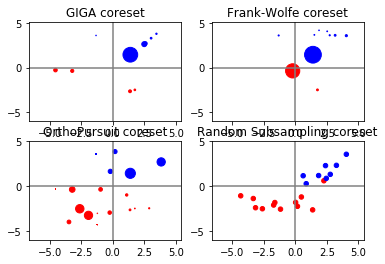

In [26]:
fig, axes = plt.subplots(2,2)
axes[0,0].set_title('GIGA coreset')
axes[0,0].scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_giga.weights())
axes[0,0].axhline(y=0, color='gray')
axes[0,0].axvline(x=0, color='gray')

axes[0,1].set_title('Frank-Wolfe coreset')
axes[0,1].scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_fw.weights())
axes[0,1].axhline(y=0, color='gray')
axes[0,1].axvline(x=0, color='gray')

axes[1,0].set_title('OrthoPursuit coreset')
axes[1,0].scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_op.weights())
axes[1,0].axhline(y=0, color='gray')
axes[1,0].axvline(x=0, color='gray')

axes[1,1].set_title('Random Subsampling coreset')
axes[1,1].scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_rs.weights())
axes[1,1].axhline(y=0, color='gray')
axes[1,1].axvline(x=0, color='gray')

## 3. Bayesian Logistic Regression

In this third part, we perform Bayesian logistic regression on the original data, the GIGA coreset and the Frank-Wolfe coreset.

### Computing MAP estimate for the original data

We first compute the MAP estimate for the parameters, $\hat{\theta}_{MAP}$, and then we plot the MAP discriminator.

In [19]:
map_theta = ed.models.PointMass(tf.Variable(tf.zeros(2)))
inference = ed.MAP({theta:map_theta}, {X:Xtr,y:Ytr.reshape((nsamples*2))})
inference.run(n_iter=5)

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


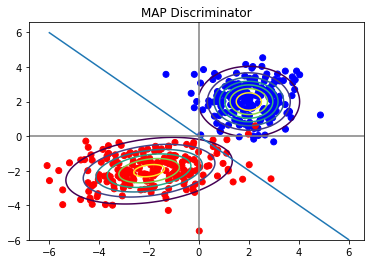

In [21]:
mapx = np.linspace(-6,6,500)
mapy = -(mapx*map_theta.eval()[0]) / map_theta.eval()[1]
plt.plot(mapx,mapy)

plt.title('MAP Discriminator')
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

xcontourgrid, ycontourgrid = np.mgrid[0:5:gridstep, 0:5:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf1.pdf(xycontourgrid))

xcontourgrid, ycontourgrid = np.mgrid[-6:2:gridstep, -6:2:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf2.pdf(xycontourgrid))

### Computing the posterior predictive for the original data

We then compute the posterior predictive via MCMC, and then we plot the contour plot of the posterior predictive.

In [22]:
mc_samples = 10000
qmc_theta = ed.models.Empirical(tf.Variable(tf.zeros((mc_samples,2))))
proposal_theta = ed.models.Normal(loc=tf.zeros(2), scale=tf.ones(2))
inference = ed.MetropolisHastings({theta:qmc_theta}, {theta:proposal_theta}, {X:Xtr,y:Ytr.reshape((nsamples*2))})
inference.run()

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 5s | Acceptance Rate: 0.001


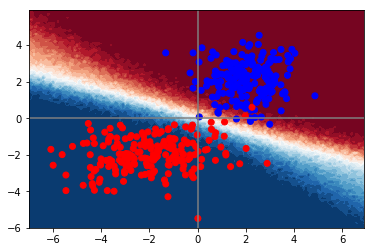

In [23]:
y_post = ed.models.Bernoulli(probs=tf.sigmoid(ed.dot(X,qmc_theta)))

ppc_samples = 100
probs_BLR = [y_post.eval(feed_dict={X:xymeshgrid}) for _ in range(ppc_samples)]
probs_BLR = np.array(probs_BLR).mean(axis=0).reshape(xmeshgrid.shape)
  
plt.contourf(xmeshgrid, ymeshgrid, probs_BLR, 25, cmap="RdBu")
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

### Upsampling the data for the GIGA coreset

We rely on an upsampling trick to manage the weight of the data provided at the end of the coreset computation-- this solution is far from ideal, and a better approach would be to redefine the model to take into accoun the weights.

In [27]:
Wt = bc_giga.weights()
Xwt = Xtr[Wt>0]
Ywt = Ytr[Wt>0]
Wt = Wt[Wt>0]

for i in range(Wt.shape[0]):
    np.vstack((Xwt, np.tile(Xwt[i,:],(np.int32(np.floor(Wt[i])),1))))
    np.vstack((Ywt, np.tile(Ywt[i,:],(np.int32(np.floor(Wt[i])),1))))

### Computing MAP estimate for the GIGA coreset

We now compute again the MAP estimate for the parameters,  $\hat{\theta}_{MAP}$, using only the coreset data, and then we plot the MAP discriminator.

In [28]:
map_theta = ed.models.PointMass(tf.Variable(tf.zeros(2)))
inference = ed.MAP({theta:map_theta}, {X:Xwt,y:Ywt.reshape((Ywt.shape[0]))})
inference.run(n_iter=5)

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


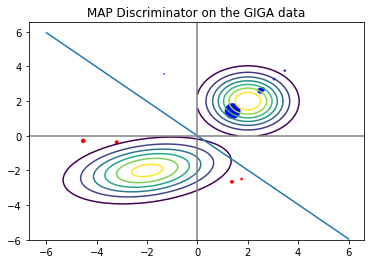

In [30]:
mapx = np.linspace(-6,6,500)
mapy = -(mapx*map_theta.eval()[0]) / map_theta.eval()[1]
plt.plot(mapx,mapy)
   
plt.title('MAP Discriminator on the GIGA data')
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_giga.weights())
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
   
xcontourgrid, ycontourgrid = np.mgrid[0:5:gridstep, 0:5:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf1.pdf(xycontourgrid))
   
xcontourgrid, ycontourgrid = np.mgrid[-6:2:gridstep, -6:2:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf2.pdf(xycontourgrid))

### Computing the posterior predictive for the GIGA coreset

We then compute the posterior predictive via MCMC, and then we plot the contour plot of the posterior predictive.

In [31]:
mc_samples = 10000
qmc_theta = ed.models.Empirical(tf.Variable(tf.zeros((mc_samples,2))))
proposal_theta = ed.models.Normal(loc=tf.zeros(2), scale=tf.ones(2))
inference = ed.MetropolisHastings({theta:qmc_theta}, {theta:proposal_theta}, {X:Xwt,y:Ywt.reshape((Ywt.shape[0]))})
inference.run()

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 0.001


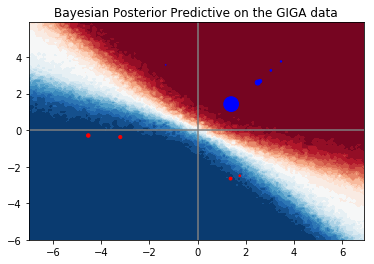

In [32]:
y_post = ed.models.Bernoulli(probs=tf.sigmoid(ed.dot(X,qmc_theta)))
   
ppc_samples = 100
probs_BLR = [y_post.eval(feed_dict={X:xymeshgrid}) for _ in range(ppc_samples)]
probs_BLR = np.array(probs_BLR).mean(axis=0).reshape(xmeshgrid.shape)
     
plt.title('Bayesian Posterior Predictive on the GIGA data')
plt.contourf(xmeshgrid, ymeshgrid, probs_BLR, 25, cmap="RdBu")
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_giga.weights())
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

### Upsampling the data for the Frank-Wolfe coreset

We rely on an upsampling trick to manage the weight of the data provided at the end of the coreset computation-- this solution is far from ideal, and a better approach would be to redefine the model to take into accoun the weights.

In [34]:
Wt = bc_fw.weights()
Xwt = Xtr[Wt>0]
Ywt = Ytr[Wt>0]
Wt = Wt[Wt>0]

for i in range(Wt.shape[0]):
    np.vstack((Xwt, np.tile(Xwt[i,:],(np.int32(np.floor(Wt[i])),1))))
    np.vstack((Ywt, np.tile(Ywt[i,:],(np.int32(np.floor(Wt[i])),1))))

### Computing MAP estimate for the Frank-Wolfe coreset

We now compute again the MAP estimate for the parameters,  $\hat{\theta}_{MAP}$, using only the coreset data, and then we plot the MAP discriminator.

In [35]:
map_theta = ed.models.PointMass(tf.Variable(tf.zeros(2)))
inference = ed.MAP({theta:map_theta}, {X:Xwt,y:Ywt.reshape((Ywt.shape[0]))})
inference.run(n_iter=5)

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


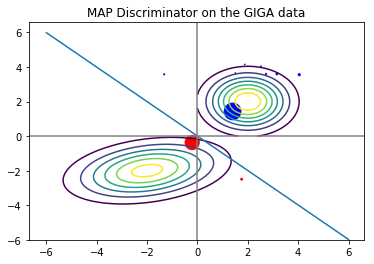

In [37]:
mapx = np.linspace(-6,6,500)
mapy = -(mapx*map_theta.eval()[0]) / map_theta.eval()[1]
plt.plot(mapx,mapy)
   
plt.title('MAP Discriminator on the Frank-Wolfe data')
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_fw.weights())
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
   
xcontourgrid, ycontourgrid = np.mgrid[0:5:gridstep, 0:5:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf1.pdf(xycontourgrid))
   
xcontourgrid, ycontourgrid = np.mgrid[-6:2:gridstep, -6:2:gridstep]
xycontourgrid = np.dstack((xcontourgrid, ycontourgrid))
plt.contour(xcontourgrid, ycontourgrid, pdf2.pdf(xycontourgrid))

### Computing the posterior predictive for the Frank-Wolfe coreset

We then compute the posterior predictive via MCMC, and then we plot the contour plot of the posterior predictive.

In [38]:
mc_samples = 10000
qmc_theta = ed.models.Empirical(tf.Variable(tf.zeros((mc_samples,2))))
proposal_theta = ed.models.Normal(loc=tf.zeros(2), scale=tf.ones(2))
inference = ed.MetropolisHastings({theta:qmc_theta}, {theta:proposal_theta}, {X:Xwt,y:Ywt.reshape((Ywt.shape[0]))})
inference.run()

/home/fmzennaro/miniconda2_1/envs/bayes3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 0.001


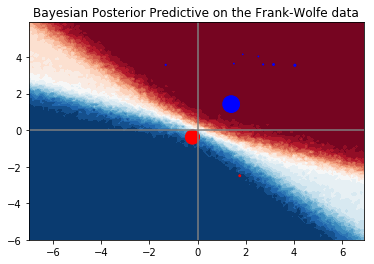

In [40]:
y_post = ed.models.Bernoulli(probs=tf.sigmoid(ed.dot(X,qmc_theta)))
   
ppc_samples = 100
probs_BLR = [y_post.eval(feed_dict={X:xymeshgrid}) for _ in range(ppc_samples)]
probs_BLR = np.array(probs_BLR).mean(axis=0).reshape(xmeshgrid.shape)
     
plt.title('Bayesian Posterior Predictive on the Frank-Wolfe data')
plt.contourf(xmeshgrid, ymeshgrid, probs_BLR, 25, cmap="RdBu")
plt.scatter(Xtr[:,0],Xtr[:,1], c=ycolors, s=bc_fw.weights())
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

## References

\[1\] Campbell, T. & Broderick, T. Automated Scalable Bayesian Inference via Hilbert Coresets arXiv preprint arXiv:1710.05053, 2017.

\[2\] Campbell, T. & Broderick, T. Bayesian coreset construction via greedy iterative geodesic ascent arXiv preprint arXiv:1802.01737, 2018

\[3\] [Bayesian Coresets: Automated, Scalable Inference](https://github.com/trevorcampbell/bayesian-coresets)

\[4\] Tran, D.; Kucukelbir, A.; Dieng, A. B.; Rudolph, M.; Liang, D. & Blei, D. M. Edward: A library for probabilistic modeling, inference, and criticism arXiv preprint arXiv:1610.09787, 2016